In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
from datetime import datetime
import wandb

warnings.filterwarnings('ignore')

# PatchTst Class:
* Preprocessing
* Feature Engineering
* Training
* Logging informative plots on WandB


Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)
Merging and cleaning data...
After merging - Train shape: (421570, 16)
After merging - Test shape: (115064, 15)
Adding time features...
Adding holiday features...
Adding lag features...
Adding lag features...
Adding store/department features...
Adding markdown features...
Adding economic features...
Adding competitive features...
Final train shape: (421570, 90)
Final test shape: (115064, 90)
Selecting best 30 features from 88 total features...
Selected features: ['Type', 'Size', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_12', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median']...
Preparing sequences for training...
Total sequences: 386102
Sequence shape: (386102, 12, 30)
Using device: cuda
Starting training...
Epoch 1/30: Train Loss: 711910663.4912, Val Loss: 556302523.5394
  MAE: 10986.4352, RMSE: 23579.1570, R2: -0.0753, WMAE: 11195.88

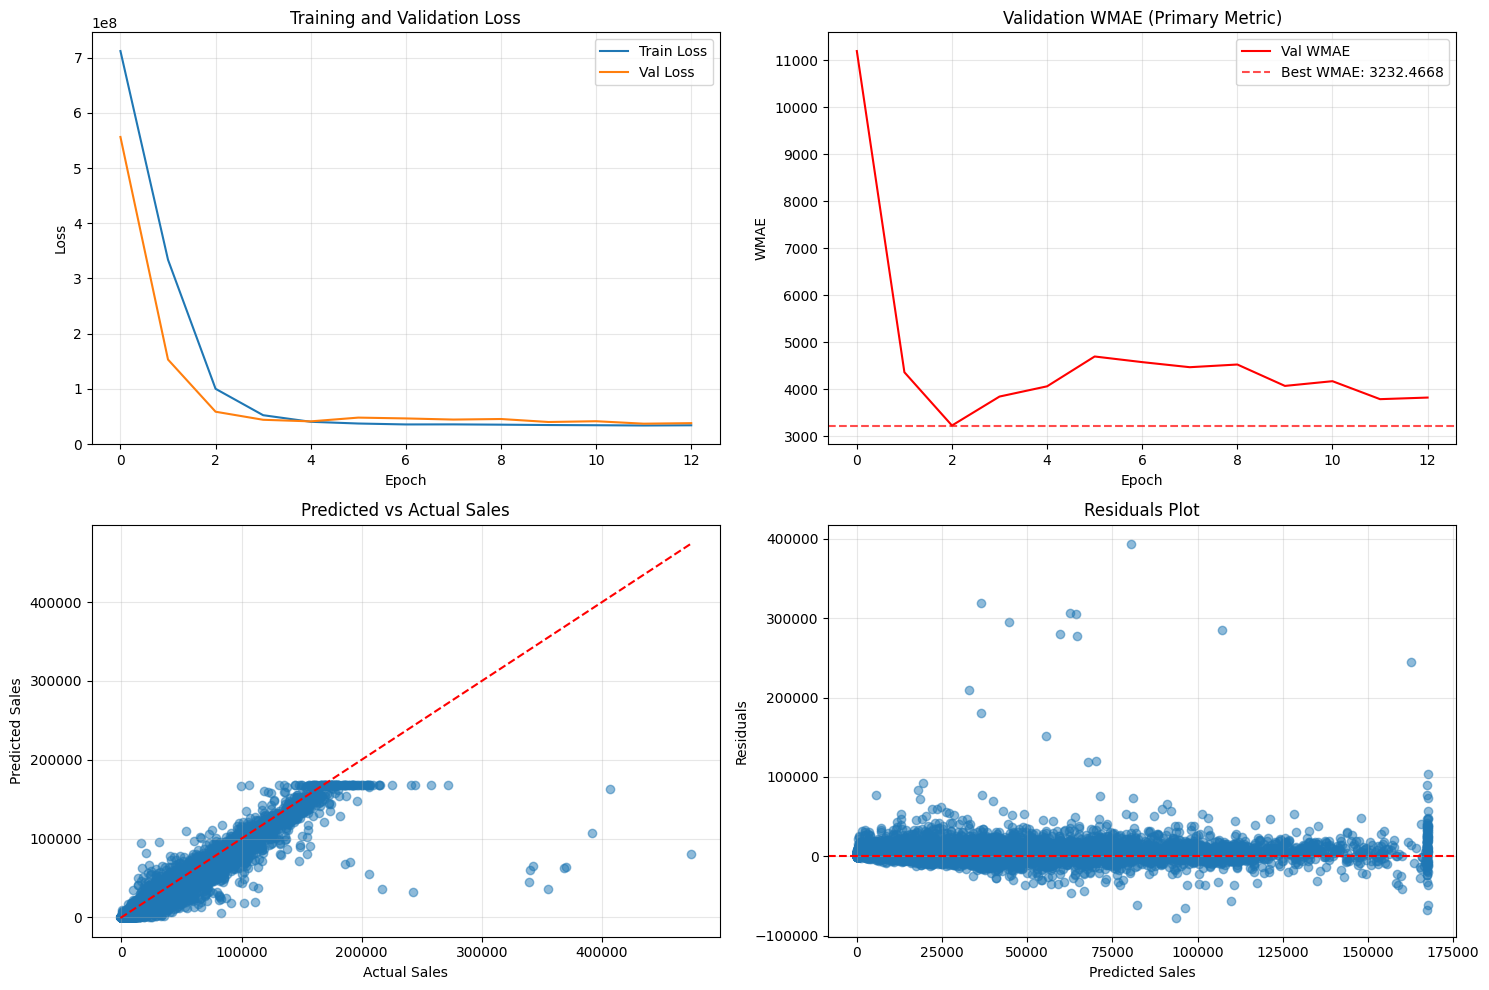


=== Final Training Results ===
Best WMAE: 3232.4668
Final MAE: 3530.3358
Final RMSE: 6161.0159
Final R2: 0.9266

=== Model Summary ===
Total parameters: 1,192,705
Trainable parameters: 1,192,705
Selected features: 30
Best WMAE achieved: 3232.4668


best_wmae,█▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
final_best_wmae,▁
final_feature_count,▁
final_test_shape,▁
final_train_shape,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
model_parameters,▁
total_features,▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁
trainable_parameters,▁



Training completed successfully!
Files generated:
- best_model.pth: Best model weights
- training_results.png: Training visualization


In [ ]:
class PatchTST(nn.Module):
    def __init__(self, input_dim, patch_size=7, d_model=64, n_heads=8, n_layers=3, dropout=0.1):
        super(PatchTST, self).__init__()
        self.patch_size = patch_size
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1000, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        batch_size, seq_len, features = x.shape

        x = self.input_projection(x)
        x = x + self.positional_encoding[:seq_len, :].unsqueeze(0)

        x = self.transformer(x)
        x = x.mean(dim=1)

        output = self.output_projection(x)
        return output.squeeze()

class WalmartSalesPreprocessor:
    def __init__(self, wandb_project="walmart-sales-prediction"):
        self.label_encoders = {}
        self.feature_stats = {}
        self.wandb_project = wandb_project
        self.scaler = StandardScaler()

        wandb.init(
            project=self.wandb_project,
            name=f"walmart-sales-patchTST-{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            config={
                "model_type": "patchTST",
                "preprocessing_steps": [
                    "time_features", "holiday_features", "lag_features",
                    "store_dept_features", "markdown_features", "economic_features",
                    "competitive_features"
                ]
            }
        )

    def load_data(self, train_path, test_path, features_path, stores_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.features_df = pd.read_csv(features_path)
        self.stores_df = pd.read_csv(stores_path)

        print(f"Train shape: {self.train_df.shape}")
        print(f"Test shape: {self.test_df.shape}")
        print(f"Features shape: {self.features_df.shape}")
        print(f"Stores shape: {self.stores_df.shape}")

        return self.train_df, self.test_df, self.features_df, self.stores_df

    def merge_and_clean_data(self):
        for df in [self.train_df, self.test_df, self.features_df]:
            df['Date'] = pd.to_datetime(df['Date'])

        self.train_df = self.train_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
        self.test_df = self.test_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

        self.train_df = self.train_df.merge(self.stores_df, on='Store', how='left')
        self.test_df = self.test_df.merge(self.stores_df, on='Store', how='left')

        mark_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for col in mark_cols:
            self.train_df[col] = self.train_df[col].fillna(0)
            self.test_df[col] = self.test_df[col].fillna(0)

        for col in ['CPI', 'Unemployment']:
            self.train_df = self.train_df.sort_values(['Store', 'Date'])
            self.test_df = self.test_df.sort_values(['Store', 'Date'])

            self.train_df[col] = self.train_df.groupby('Store')[col].ffill().bfill()
            self.test_df[col] = self.test_df.groupby('Store')[col].ffill().bfill()

            if self.train_df[col].isna().any() or self.test_df[col].isna().any():
                overall_median = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(overall_median)
                self.test_df[col] = self.test_df[col].fillna(overall_median)

        self.train_df['IsHoliday'] = self.train_df['IsHoliday'].astype(int)
        self.test_df['IsHoliday'] = self.test_df['IsHoliday'].astype(int)

        self.label_encoders['Type'] = LabelEncoder()
        self.train_df['Type'] = self.label_encoders['Type'].fit_transform(self.train_df['Type'])
        self.test_df['Type'] = self.label_encoders['Type'].transform(self.test_df['Type'])

        print(f"After merging - Train shape: {self.train_df.shape}")
        print(f"After merging - Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def add_time_features(self):
        for df in [self.train_df, self.test_df]:
            df['Year'] = df['Date'].dt.year
            df['Month'] = df['Date'].dt.month
            df['Week'] = df['Date'].dt.isocalendar().week
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            df['Quarter'] = df['Date'].dt.quarter
            df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
            df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
            df['DayOfMonth'] = df['Date'].dt.day
            df['DayOfYear'] = df['Date'].dt.dayofyear

            df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
            df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
            df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
            df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
            df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
            df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

            df['IsWeekend'] = (df['DayOfWeek'].isin([5, 6])).astype(int)
            df['IsBackToSchool'] = ((df['Month'] == 8) | (df['Month'] == 9)).astype(int)
            df['IsHolidaySeason'] = ((df['Month'] == 11) | (df['Month'] == 12)).astype(int)
            df['IsNewYear'] = (df['Month'] == 1).astype(int)
            df['IsSummer'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)

        return self.train_df, self.test_df

    def add_holiday_features(self):
        super_bowl_dates = pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
        labor_day_dates = pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'])
        thanksgiving_dates = pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
        christmas_dates = pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])

        for df in [self.train_df, self.test_df]:
            df['IsSuperBowl'] = df['Date'].isin(super_bowl_dates).astype(int)
            df['IsLaborDay'] = df['Date'].isin(labor_day_dates).astype(int)
            df['IsThanksgiving'] = df['Date'].isin(thanksgiving_dates).astype(int)
            df['IsChristmas'] = df['Date'].isin(christmas_dates).astype(int)

        self.train_df = self._add_holiday_proximity(self.train_df)
        self.test_df = self._add_holiday_proximity(self.test_df)

        return self.train_df, self.test_df

    def _add_holiday_proximity(self, df):
        df = df.copy()
        df['HolidayProximity'] = 0

        holidays = df.loc[df['IsHoliday'] == 1, 'Date'].unique()

        for holiday in holidays:
            days_diff = (df['Date'] - holiday).dt.days

            mask_2weeks_before = (days_diff >= -14) & (days_diff < -7)
            mask_1week_before = (days_diff >= -7) & (days_diff < 0)
            mask_holiday = (days_diff == 0)
            mask_1week_after = (days_diff > 0) & (days_diff <= 7)
            mask_2weeks_after = (days_diff > 7) & (days_diff <= 14)

            df.loc[mask_2weeks_before, 'HolidayProximity'] = -2
            df.loc[mask_1week_before, 'HolidayProximity'] = -1
            df.loc[mask_holiday, 'HolidayProximity'] = 0
            df.loc[mask_1week_after, 'HolidayProximity'] = 1
            df.loc[mask_2weeks_after, 'HolidayProximity'] = 2

        return df

    def add_lag_features(self):
        print("Adding lag features...")

        self.train_df = self.train_df.sort_values(['Store', 'Dept', 'Date'])
        self.test_df = self.test_df.sort_values(['Store', 'Dept', 'Date'])

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.train_df[lag_col] = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

        last_train_sales = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].last().reset_index()
        last_train_sales.columns = ['Store', 'Dept', 'Last_Known_Sales']

        self.test_df = self.test_df.merge(last_train_sales, on=['Store', 'Dept'], how='left')

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.test_df[lag_col] = self.test_df['Last_Known_Sales']

        lag_cols = [f'Sales_Lag_{lag}' for lag in [1, 2, 4, 8, 12]]
        for col in lag_cols:
            self.train_df[col] = self.train_df.groupby(['Store', 'Dept'])[col].ffill()
            self.train_df[col] = self.train_df[col].fillna(self.train_df[col].median())
            if col in self.test_df.columns:
                self.test_df[col] = self.test_df[col].fillna(self.test_df[col].median())

        return self.train_df, self.test_df

    def add_store_dept_features(self):
        store_stats = self.train_df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_stats.columns = ['Store', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median', 'Store_Sales_Min', 'Store_Sales_Max']

        dept_stats = self.train_df.groupby('Dept')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        dept_stats.columns = ['Dept', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Median', 'Dept_Sales_Min', 'Dept_Sales_Max']

        store_dept_stats = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_dept_stats.columns = ['Store', 'Dept', 'StoreDept_Sales_Mean', 'StoreDept_Sales_Std', 'StoreDept_Sales_Median', 'StoreDept_Sales_Min', 'StoreDept_Sales_Max']

        holiday_stats = self.train_df[self.train_df['IsHoliday'] == 1].groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std']).reset_index()
        holiday_stats.columns = ['Store', 'Dept', 'Holiday_Sales_Mean', 'Holiday_Sales_Std']

        seasonal_stats = self.train_df.groupby(['Store', 'Dept', 'Quarter'])['Weekly_Sales'].mean().reset_index()
        seasonal_stats = seasonal_stats.pivot(index=['Store', 'Dept'], columns='Quarter', values='Weekly_Sales').reset_index()
        seasonal_stats.columns = ['Store', 'Dept', 'Q1_Sales_Mean', 'Q2_Sales_Mean', 'Q3_Sales_Mean', 'Q4_Sales_Mean']

        for stats_df in [store_stats, dept_stats, store_dept_stats, holiday_stats, seasonal_stats]:
            merge_cols = [col for col in stats_df.columns if col in ['Store', 'Dept']]
            self.train_df = self.train_df.merge(stats_df, on=merge_cols, how='left')
            self.test_df = self.test_df.merge(stats_df, on=merge_cols, how='left')

        stat_cols = [col for col in self.train_df.columns if any(x in col for x in ['_Mean', '_Std', '_Median', '_Min', '_Max', 'Holiday_', 'Q1_', 'Q2_', 'Q3_', 'Q4_'])]

        for col in stat_cols:
            if col in self.train_df.columns:
                fill_value = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(fill_value)
                self.test_df[col] = self.test_df[col].fillna(fill_value)

        return self.train_df, self.test_df

    def add_markdown_features(self):
        markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for df in [self.train_df, self.test_df]:
            df['Total_MarkDown'] = df[markdown_cols].sum(axis=1)
            df['Active_MarkDowns'] = (df[markdown_cols] > 0).sum(axis=1)
            df['Max_MarkDown'] = df[markdown_cols].max(axis=1)
            df['MarkDown_Intensity'] = df['Total_MarkDown'] / (df['Size'] + 1)

            df['MarkDown_per_Dept'] = df['Total_MarkDown'] / (df['Dept'] + 1)
            df['Has_MarkDown'] = (df['Total_MarkDown'] > 0).astype(int)

            for i, col in enumerate(markdown_cols, 1):
                df[f'MarkDown{i}_Ratio'] = df[col] / (df['Total_MarkDown'] + 1)

        return self.train_df, self.test_df

    def add_economic_features(self):
        for df in [self.train_df, self.test_df]:
            df['Economic_Health'] = df['CPI'] / (df['Unemployment'] + 0.1)
            df['Fuel_Impact'] = df['Fuel_Price'] / df['CPI']
            df['CPI_Normalized'] = df['CPI'] / df['CPI'].mean()
            df['Unemployment_Normalized'] = df['Unemployment'] / df['Unemployment'].mean()
            df['Fuel_Price_Normalized'] = df['Fuel_Price'] / df['Fuel_Price'].mean()

            df['CPI_Change'] = df.groupby('Store')['CPI'].pct_change().fillna(0)
            df['Unemployment_Change'] = df.groupby('Store')['Unemployment'].pct_change().fillna(0)
            df['Fuel_Price_Change'] = df.groupby('Store')['Fuel_Price'].pct_change().fillna(0)

        return self.train_df, self.test_df

    def add_competitive_features(self):
        self.train_df['Size_Rank'] = self.train_df.groupby('Date')['Size'].rank(pct=True)
        self.test_df['Size_Rank'] = self.test_df.groupby('Date')['Size'].rank(pct=True)

        store_type_counts = self.train_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.train_df = self.train_df.merge(store_type_counts, on=['Type', 'Date'], how='left')

        store_type_counts_test = self.test_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.test_df = self.test_df.merge(store_type_counts_test, on=['Type', 'Date'], how='left')

        self.train_df['Type_Concentration'] = self.train_df['Type_Count'] / self.train_df.groupby('Date')['Type_Count'].transform('sum')
        self.test_df['Type_Concentration'] = self.test_df['Type_Count'] / self.test_df.groupby('Date')['Type_Count'].transform('sum')

        dept_popularity = self.train_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.train_df = self.train_df.merge(dept_popularity, on=['Dept', 'Date'], how='left')

        dept_popularity_test = self.test_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.test_df = self.test_df.merge(dept_popularity_test, on=['Dept', 'Date'], how='left')

        return self.train_df, self.test_df

    def preprocess_complete(self, train_path, test_path, features_path, stores_path):
        print("Loading data...")
        self.load_data(train_path, test_path, features_path, stores_path)

        print("Merging and cleaning data...")
        self.merge_and_clean_data()

        print("Adding time features...")
        self.add_time_features()

        print("Adding holiday features...")
        self.add_holiday_features()

        print("Adding lag features...")
        self.add_lag_features()

        print("Adding store/department features...")
        self.add_store_dept_features()

        print("Adding markdown features...")
        self.add_markdown_features()

        print("Adding economic features...")
        self.add_economic_features()

        print("Adding competitive features...")
        self.add_competitive_features()

        print(f"Final train shape: {self.train_df.shape}")
        print(f"Final test shape: {self.test_df.shape}")

        wandb.log({
            "final_train_shape": self.train_df.shape[0],
            "final_test_shape": self.test_df.shape[0],
            "final_feature_count": self.train_df.shape[1]
        })

        return self.train_df, self.test_df

    def get_feature_columns(self):
        exclude_cols = ['Weekly_Sales', 'Date', 'Last_Known_Sales']
        feature_cols = [col for col in self.train_df.columns if col not in exclude_cols]
        return feature_cols

    def select_best_features(self, train_df, feature_cols, n_features=30):
        print(f"Selecting best {n_features} features from {len(feature_cols)} total features...")

        X = train_df[feature_cols].fillna(0)
        y = train_df['Weekly_Sales']

        selector = SelectKBest(score_func=f_regression, k=n_features)
        X_selected = selector.fit_transform(X, y)

        selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
        print(f"Selected features: {selected_features[:10]}...")

        return selected_features

    def prepare_sequences(self, df, feature_cols, seq_length=4):
        df_sorted = df.sort_values(['Store', 'Dept', 'Date'])

        sequences = []
        targets = []

        for (store, dept), group in df_sorted.groupby(['Store', 'Dept']):
            if len(group) < seq_length:
                continue

            group_features = group[feature_cols].fillna(0).values
            group_targets = group['Weekly_Sales'].values

            for i in range(len(group) - seq_length + 1):
                sequences.append(group_features[i:i + seq_length])
                targets.append(group_targets[i + seq_length - 1])

        return np.array(sequences), np.array(targets)

    def calculate_wmae(self, y_true, y_pred, is_holiday):
        weights = np.where(is_holiday, 5.0, 1.0)
        weighted_errors = weights * np.abs(y_true - y_pred)
        wmae = np.sum(weighted_errors) / np.sum(weights)
        return wmae

    def train_model(self, train_df, selected_features, seq_length=6, batch_size=64, epochs=30, lr=0.0003):
        print("Preparing sequences for training...")

        X_seq, y_seq = self.prepare_sequences(train_df, selected_features, seq_length)

        print(f"Total sequences: {len(X_seq)}")
        print(f"Sequence shape: {X_seq.shape}")

        holiday_seq = []
        for (store, dept), group in train_df.groupby(['Store', 'Dept']):
            group_sorted = group.sort_values('Date')
            if len(group_sorted) >= seq_length:
                for i in range(len(group_sorted) - seq_length + 1):
                    # Use the holiday status of the target week (last week in sequence)
                    holiday_seq.append(group_sorted.iloc[i + seq_length - 1]['IsHoliday'])

        holiday_seq = np.array(holiday_seq)

        X_train, X_val, y_train, y_val, holiday_train, holiday_val = train_test_split(
            X_seq, y_seq, holiday_seq, test_size=0.2, random_state=42
        )

        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
        X_train_scaled = X_train_scaled.reshape(X_train.shape)

        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
        X_val_scaled = X_val_scaled.reshape(X_val.shape)

        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_scaled),
            torch.FloatTensor(y_train)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val_scaled),
            torch.FloatTensor(y_val)
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        model = PatchTST(
            input_dim=len(selected_features),
            patch_size=seq_length,
            d_model=64,
            n_heads=8,
            n_layers=4,
            dropout=0.15
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )

        train_losses = []
        val_losses = []
        val_wmaes = []
        best_wmae = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        print("Starting training...")
        for epoch in range(epochs):
            model.train()
            train_loss = 0

            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            val_predictions = []
            val_actuals = []

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()

                    val_predictions.extend(outputs.cpu().numpy())
                    val_actuals.extend(batch_y.cpu().numpy())

            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            mae = mean_absolute_error(val_actuals, val_predictions)
            rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
            r2 = r2_score(val_actuals, val_predictions)

            wmae = self.calculate_wmae(
                np.array(val_actuals),
                np.array(val_predictions),
                holiday_val
            )
            val_wmaes.append(wmae)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, WMAE: {wmae:.4f}")

            # Learning rate scheduling
            scheduler.step(val_loss)

            # Early stopping based on WMAE
            if wmae < best_wmae:
                best_wmae = wmae
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_mae": mae,
                "val_rmse": rmse,
                "val_r2": r2,
                "val_wmae": wmae,
                "best_wmae": best_wmae,
                "learning_rate": optimizer.param_groups[0]['lr']
            })

        model.load_state_dict(torch.load('best_model.pth'))
        self.model = model
        self.device = device

        plt.figure(figsize=(15, 10))

        # Loss curves
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # WMAE curve
        plt.subplot(2, 2, 2)
        plt.plot(val_wmaes, label='Val WMAE', color='red')
        plt.axhline(y=best_wmae, color='red', linestyle='--', alpha=0.7, label=f'Best WMAE: {best_wmae:.4f}')
        plt.xlabel('Epoch')
        plt.ylabel('WMAE')
        plt.title('Validation WMAE (Primary Metric)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Predictions vs Actual
        plt.subplot(2, 2, 3)
        plt.scatter(val_actuals, val_predictions, alpha=0.5)
        plt.plot([min(val_actuals), max(val_actuals)], [min(val_actuals), max(val_actuals)], 'r--')
        plt.xlabel('Actual Sales')
        plt.ylabel('Predicted Sales')
        plt.title('Predicted vs Actual Sales')
        plt.grid(True, alpha=0.3)

        # Residuals plot
        plt.subplot(2, 2, 4)
        residuals = np.array(val_actuals) - np.array(val_predictions)
        plt.scatter(val_predictions, residuals, alpha=0.5)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Predicted Sales')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
        plt.show()

        wandb.log({"training_plot": wandb.Image('training_results.png')})

        print(f"\n=== Final Training Results ===")
        print(f"Best WMAE: {best_wmae:.4f}")
        print(f"Final MAE: {mae:.4f}")
        print(f"Final RMSE: {rmse:.4f}")
        print(f"Final R2: {r2:.4f}")

        return model, train_losses, val_losses, val_wmaes, best_wmae

def main():
    preprocessor = WalmartSalesPreprocessor()

    train_df, test_df = preprocessor.preprocess_complete(
        train_path = '/content/drive/MyDrive/ML/final/train.csv',
        test_path = '/content/drive/MyDrive/ML/final/test.csv',
        features_path = '/content/drive/MyDrive/ML/final/features.csv',
        stores_path = '/content/drive/MyDrive/ML/final/stores.csv'
    )

    feature_cols = preprocessor.get_feature_columns()
    selected_features = preprocessor.select_best_features(train_df, feature_cols, n_features=30)

    model, train_losses, val_losses, val_wmaes, best_wmae = preprocessor.train_model(
        train_df,
        selected_features,
        seq_length=12,
        batch_size=64,
        epochs=30,
        lr=0.0003
    )

    wandb.log({
        "final_best_wmae": best_wmae,
        "total_features": len(selected_features),
        "model_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
    })

    print(f"\n=== Model Summary ===")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Best WMAE achieved: {best_wmae:.4f}")

    wandb.finish()

    print("\nTraining completed successfully!")
    print("Files generated:")
    print("- best_model.pth: Best model weights")
    print("- training_results.png: Training visualization")

    return preprocessor, model, best_wmae

if __name__ == "__main__":
    preprocessor, model, best_wmae = main()